# Getting seed encoder model from linear unmixing data of step 4

In [1]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import gaussian_kde

import torch
import torch .nn as nn
import torch .optim as optim

import json

import gc

from tqdm.notebook import tqdm

plt.rcParams['text.usetex'] = True

# Create model to regress abundances for individual spectra

### Define Linear Mixing Model 

In [2]:
class LinearMixingSOCPredictor(nn.Module):
    def __init__(self, seedFs, seedMs, trueMsoc, rhorad, seedrrsoc, nepochs):
        super().__init__()
        # fixed quantities
        self.rhorad = rhorad;
        self.fs     = seedFs;
        self.truemsoc = trueMsoc;
        
        # model parameters
        self.rrsoc  = nn.Parameter(seedrrsoc);
        self.ms     = nn.Parameter(seedMs);
        
        # model output
        self.Ihat   = 0;
        
        # variables for tracking optimization
        self.epoch = 0;
        self.nepochs = nepochs;
        
        self.lsq = np.zeros(nepochs);
        self.loss = np.zeros(nepochs);
        self.socbias = np.zeros(nepochs);
        self.bdsALoss = np.zeros(nepochs);
        self.diffloss1 = np.zeros(nepochs);
        self.difflossfull = np.zeros(nepochs);
        
        
    def forward(self, y):
        rrFull    = torch.cat((self.rhorad,self.rrsoc.unsqueeze(0)))
        mFull     = (self.ms.t() / torch.sum(self.ms)).t()
        self.Ihat = torch.matmul(torchA(mFull,rrFull).float(),self.fs.float())
                
        # Add in a fake Lagrange multiplier to discourage abundances < 0.001 or > 0.999
        oobsA = torch.sum((mFull < 0.001).float() * (mFull - 0.001)**2) 
        oobsA = oobsA + torch.sum((mFull > 0.999).float() * (mFull + 0.001 - 1.0) **2)
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.Ihat) ** 2)
        self.diffloss1[self.epoch] = diffloss.detach().item();
        
        diffloss += torch.sum(torch.diff(torch.diff(self.Ihat)) ** 2)
        
        # Compute the loss function, which is the mean-squared error between data and prediction,
        # with a multiplicative factor for our fake Lagrange multipliers
        lsq = torch.sum((y - self.Ihat) ** 2)
        loss = lsq * (1 + 100.0* diffloss + 100.0*oobsA)
        
        # Report optimization statistics
        self.lsq[self.epoch]  = lsq.detach().item()
        self.loss[self.epoch] = loss.detach().item();
        self.socbias[self.epoch]  = self.truemsoc - mFull[-1];
        self.bdsALoss[self.epoch] = oobsA.detach().item();
        self.difflossfull[self.epoch] = diffloss.detach().item();
        
        self.epoch += 1;
        
        return loss
    

### Define encoder which converts spectrum to abundances

In [3]:
class LinearMixingEncoder(nn.Module):
    def __init__(self, M, K, hidden_size):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.BatchNorm1d(M),
            nn.Linear(M, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            
            # Collection of hidden layers
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            
            # Convert to vector of mass abundances.
            nn.Linear(hidden_size, K), 
            
            # No subsequent BatchNorm on last layer.
            
            # Use leaky ReLU: has gradient !=0 at large negative values
            # so that very small abundances (large neg. values at this layer)
            # sit in a region of nonvanishing gradient
            nn.LeakyReLU()            
        )
        
        # Softmax to ensure abundances add up to 1
        self.smax = nn.Softmax() 
        
    def forward(self, y):
        y_mlp = self.mlp(y);
        ms = self.smax(y_mlp);
        return ms

### Run through picklefiles, collect abundances regressed and corresponding spectra

In [4]:
# Set analysis parameters
KEndmembers = 90
MSpectra = 2151

In [5]:
def A(ms,rhorads) :
    tA = ms / rhorads
    return (tA.T / np.sum(tA)).T

In [6]:
import os

# Get number of spectra to analyze
dir_path = r'./results/step4/'
resultsDirContents = [entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry)) and "batch" in entry and entry.split(".")[-1] == "pkl"]
NSpectra = len(resultsDirContents)

In [17]:
import pickle

# Create spectra lists
Is = np.zeros([NSpectra,MSpectra])

# Create model parameter lists
Fs = np.zeros([KEndmembers,MSpectra])
rhorads = np.zeros(KEndmembers)

# Create abundance list
Ms = np.zeros([NSpectra,KEndmembers])

# Create msoc list
trueMSOC = np.zeros(NSpectra)

# Populate F
with open(dir_path+resultsDirContents[0], 'rb') as file:
        (model,seedMs,seedrrsoc,dataIndices,msoc) = pickle.load(file)
        Fs = np.array(model.fs.tolist())
        rhorads[:-1] = np.array(model.rhorad.tolist())
        rhorads[-1] = model.rrsoc.detach().item()
        
# Populate lists
for iSpec in tqdm(range(len(resultsDirContents))) :
    with open(dir_path+resultsDirContents[iSpec], 'rb') as file:
        (model,_,_,_,msoc) = pickle.load(file)
        
        tcorrms = np.array(model.ms.tolist())[:-1]
        tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
        tcorrms = (tcorrms.T / (np.sum(tcorrms)) * (1-msoc)).T
        
        Ms[iSpec,:-1]   = tcorrms
        Ms[iSpec,-1]    = msoc
        trueMSOC[iSpec] = msoc
        
        Is[iSpec,:] = np.dot(A(Ms[iSpec,:],rhorads),Fs)
        


  0%|          | 0/121374 [00:00<?, ?it/s]

### Train seed encoder model

In [14]:
print("Pytorch CUDA Version is ", torch.version.cuda)
print("Whether CUDA is supported by our system:", torch.cuda.is_available())
cuda_id = torch.cuda.current_device()
print("Name of the current CUDA Device: ", torch.cuda.get_device_name(cuda_id))
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Pytorch CUDA Version is  11.7
Whether CUDA is supported by our system: True
Name of the current CUDA Device:  NVIDIA GeForce RTX 4090
cuda


In [18]:
# Truth-level outputs: regressed abundances from an LMM
tMs  = torch.tensor(Ms.tolist()).to(device)

# Truth-level inputs: Individual spectra
tIs = torch.tensor(Is.tolist()).to(device)

# Training settings, optimizer declarations
nepochs = 20000
model = LinearMixingEncoder(MSpectra, KEndmembers, 512).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.000005, betas=(0.99,0.999))
preds = []

In [19]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

1944360


In [20]:
# Optimizer tracking
cEpoch = 0
lossTracking = np.zeros(nepochs);

In [ ]:
for epoch in tqdm(range(nepochs)) :
    preds = model(tIs)
    loss = (preds - tMs)**2
    e = torch.mean(loss)
    e.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossTracking[cEpoch] = e.detach().item()
    cEpoch += 1

print("Epoch ",epoch,": ", lossTracking[-1], lossTracking[-1] / (0.01 ** 2) / (KEndmembers))

### Check training output

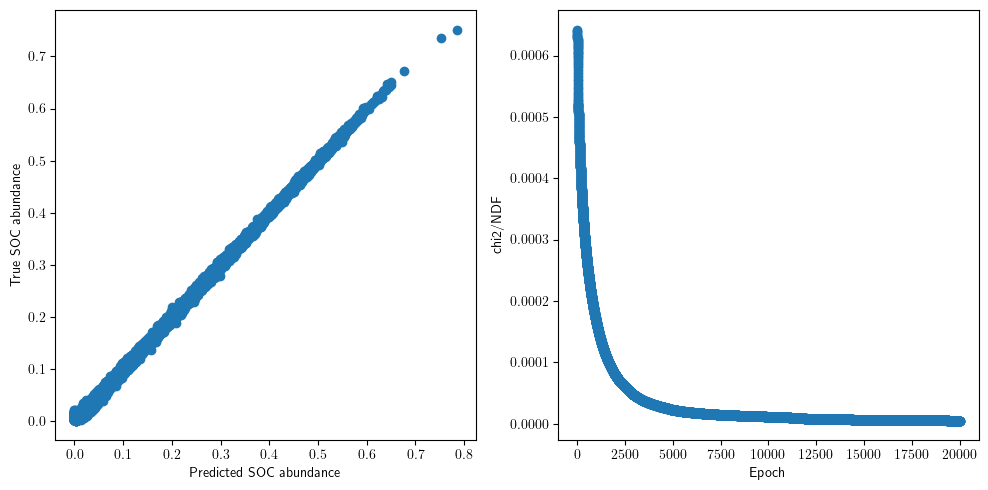

In [35]:
_, axarr = plt.subplots(1,2,figsize=(10,5))

axarr[0].scatter(Ms[:,-1],np.array(preds[:,-1].tolist()))
axarr[0].set_xlabel("True SOC abundance")
axarr[0].set_ylabel("Predicted SOC abundance")

axarr[1].scatter([i for i in range(lossTracking.shape[0])],lossTracking)
axarr[1].set_xlabel("Epoch")
axarr[1].set_ylabel("chi2/NDF")

plt.tight_layout()
plt.show()

In [36]:
import pickle

with open('step6_fullFit_E20k_lr0p000005_b1_0p99_b2_0p999.pkl', 'wb') as file:
        pickle.dump((model,optimizer,Is,Fs,Ms,rhorads,trueMSOC,preds,lossTracking), file)

## Check performance on real data

In [ ]:
import pickle

(model,optimizer,Is,Fs,Ms,rhorads,trueMSOC,preds,lossTracking) = ([],[],[],[],[],[],[],[],[])
with open('results/step6/step6_fullFit_E20k_lr0p000005_b1_0p99_b2_0p999.pkl', 'rb') as file:
        (model,optimizer,Is,Fs,Ms,rhorads,trueMSOC,preds,lossTracking) = pickle.load(file)
        
model.to(device)

In [ ]:
data = np.loadtxt("../data/RaCA-spectra-raw.txt",
                 delimiter=",", dtype=str)

In [ ]:
data[0,2152:]
sample_top   = data[1:,2153].astype('float32')
sample_bot   = data[1:,2154].astype('float32')
sample_txtr  = data[1:,2156]
sample_bd    = data[1:,2158].astype('float32')
sample_bdsd  = data[1:,2159].astype('float32')
sample_soc   = data[1:,2162].astype('float32')
sample_socsd = data[1:,2163].astype('float32')

In [ ]:
dataI = data[1:,1:2152].astype('float32')
XF = np.array([x for x in range(350,2501)]);

In [ ]:
def postProcessSpectrum(xin,xout,refin) :
    return np.interp(xout, xin, refin)

for iSpec in tqdm(range(dataI.shape[0])) :
            
    wavelengths = [x for x in range(350,2501)]
    reflectance = dataI[iSpec,:]
    
    newwave = np.array([wavelengths[i] for i in range(len(wavelengths)) if reflectance[i] is not None and reflectance[i] > 0.0 and reflectance[i] <= 1.0])
    newref  = np.array([reflectance[i] for i in range(len(reflectance)) if reflectance[i] is not None and reflectance[i] > 0.0 and reflectance[i] <= 1.0])
    
    dataI[iSpec,:] = postProcessSpectrum(newwave,XF,newref)

In [ ]:
preds = model(dataI)

In [ ]:
plt.scatter(sample_soc,np.array(preds[:,-1].tolist()))
plt.set_xlabel("True SOC abundance")
plt.set_ylabel("Predicted SOC abundance")